# Quick Start

> meow Introduction and Quick Start

In [1]:
from typing import List

import meow as mw
import numpy as np

## Installation

```sh
pip install meow-sim
```

## Quick Start

### 1. Structure
First create the structures to be simulated. A {class}`~.meow.structures.Structure` is a collection of a {class}`~.meow.geometries.Geometry` with a {class}`~.meow.materials.Material`. 

:::{note}
`meow` expects the propagation direction to be the `z`-axis! This makes the `zx`-plane parallel with the chip and the `y`-axis perpendicular to the chip. Keep this in mind when creating your structures.
:::

In [2]:
length = 10.0

oxide = mw.Structure(
    material=mw.silicon_oxide,
    geometry=mw.Box(
        x_min=-1.0,
        x_max=1.0,
        y_min=-1.0,
        y_max=0.0,
        z_min=0.0,
        z_max=length,
    ),
)

core = mw.Structure(
    material=mw.silicon,
    geometry=mw.Box(
        x_min=-0.45 / 2,
        x_max=0.45 / 2,
        y_min=0.0,
        y_max=0.22,
        z_min=0,
        z_max=length,
    ),
)

structures = [oxide, core]
mw.visualize(structures)

:::{note} 
you can also extrude structures from a gds file. See {class}`~.meow.gds_structures.GdsExtrusionRule`. 
:::

### 2. Cells

Once you have a list of {class}`~.meow.structures.Structure` objects, they need to be divided into cells. A {class}`~.meow.cell.Cell` is a combination of those structures with 2D meshing info ({class}`~.meow.mesh.Mesh2d`) and a cell length.

In [3]:
num_cells = 5

cells = mw.create_cells(
    structures=structures,
    mesh=mw.Mesh2D(
        x=np.linspace(-1, 1, 101),
        y=np.linspace(-1, 1, 101),
        # specify possible conformal mesh specifications here:
        # bend_radius=2.0,
        # bend_axis=1,
        ez_interfaces=True,
    ),
    Ls=np.array([length / num_cells for _ in range(num_cells)]),
)

A cell should be a region of (approximate) constant cross section. We can use the {func}`~.meow.visualize.visualize` function to show the cross section of a cell:

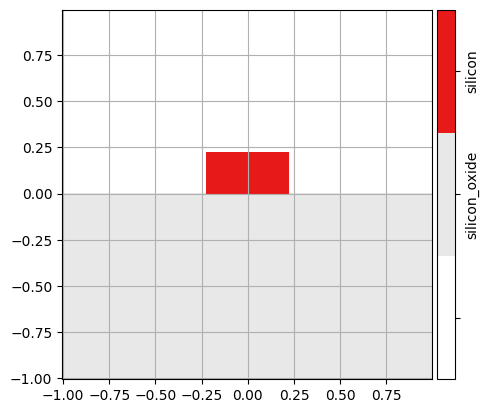

In [4]:
mw.visualize(cells[0])

### 3. Cross Sections
A {class}`~.meow.cell.Cell` contains all the {class}`~.meow.structures.Structure` info, but does not take any {class}`~.meow.environment.Environment` information (such as temparature or wavelength) into account. This information is important as it influences the refractive index of the {class}`~.meow.cross_section.CrossSection`.

Therefore, combining a {class}`~.meow.cell.Cell` with an {class}`~.meow.environment.Environment` yields a {class}`~.meow.cross_section.CrossSection`:

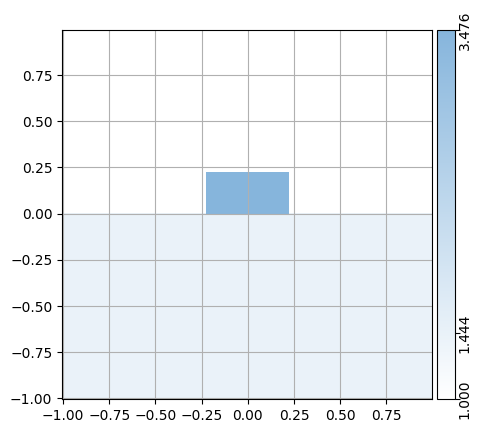

In [5]:
env = mw.Environment(wl=1.55, T=25.0)
css = [mw.CrossSection.from_cell(cell=cell, env=env) for cell in cells]
mw.visualize(css[0])

### 4. Find Modes (FDE)
We can now compute multiple {class}`~.meow.modes.Modes` per {class}`~.meow.cross_section.CrossSection` using {func}`~.meow.fde.tidy3d.compute_modes`:

In [6]:
num_modes = 4

modes: List[List[mw.Mode]] = []
for cs in css:
    modes_in_cs = mw.compute_modes(cs, num_modes=num_modes)
    modes.append(modes_in_cs)

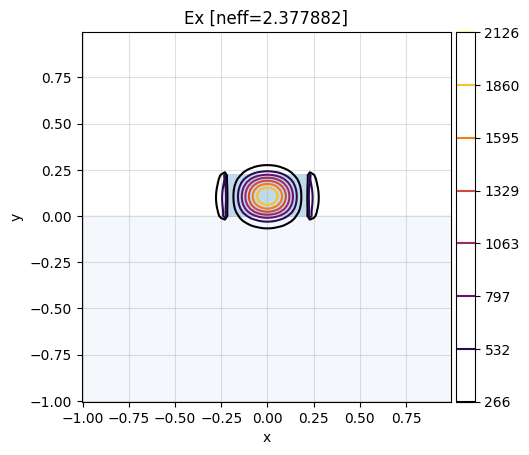

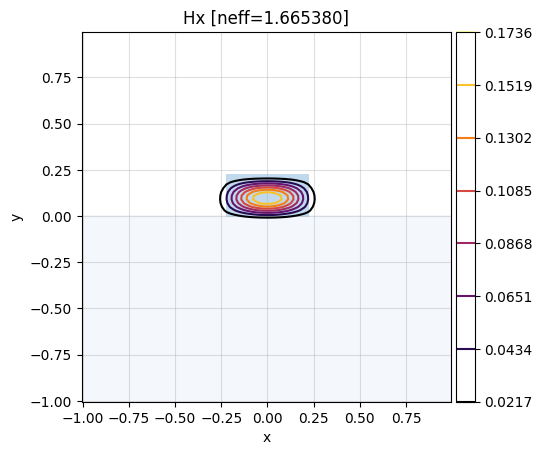

In [7]:
# show Ex component of the first mode (idx 0)
# of the first cell (idx 0):
mw.visualize(modes[0][0], fields=["Ex"])
# show Hx component of the second mode (idx 1)
# of the first cell (idx 0):
mw.visualize(modes[0][1], fields=["Hx"])

:::{note} 
above, the {class}`~.meow.modes.Modes` of the {class}`~.meow.cross_section.CrossSection` are calculated sequentially. However, you're invited to try calculating the modes concurrently as well 😉
:::

### 5. Calculate S-matrix (EME)

The S-matrix of a collection of modes can now easily be calculated with {func}`~.meow.eme.tidy3d.compute_s_matrix`. This step uses the [sax](https://github.com/flaport/sax) circuit solver under the hood.
The resulting S-matrix has is formated such that `S[0][0]` is the complex reflection coefficient from the fundamental mode into the backwards propagating fundamental mode. `S[num_modes][0]` is the transmission from the fundamental mode into the fundamental mode, following the pattern `S[<to_port>][<from_port>]`. The mapping from ports to indices is provided in `port_map`.

{'left@0': 0, 'left@1': 1, 'left@2': 2, 'left@3': 3, 'right@0': 4, 'right@1': 5, 'right@2': 6, 'right@3': 7}


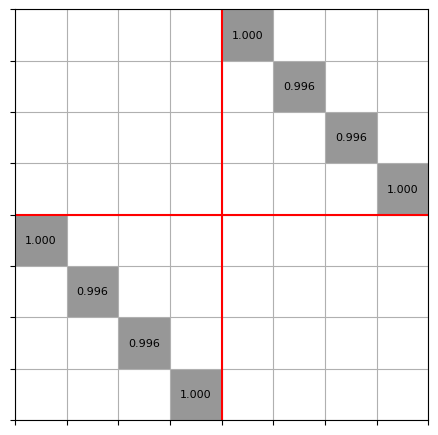

In [8]:
S, port_map = mw.compute_s_matrix(modes, cells)

print(port_map)
mw.visualize((abs(S), port_map))

That's it! this was a quick introduction to the `meow` library!